# Description

This project aims to build a classifier to classify 8 categories of fish species: Albacore tuna, Bigeye tuna, Yellowfin tuna, Mahi Mahi, Opah, Sharks, Other (meaning that there are fish present but not in the above categories)


# 1. Data Preparation and Organization

Data is downloaded from [Kaggle](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/data).

Organizations:

1. Each category is stored in different folder.

2. We will divide data into train (90%) and validation (10%) sets. 

3. If the dataset is big, we also create a sample directories with smaller train and validation datasets for quick experimentation

In [1]:
#Verify we are in the project directory
%pwd

u'/home/tnaduc/Documents/DeepLearning/Projects/FishClassification'

In [3]:
import os, sys
current_dir = os.getcwd()
PROJECT_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir+'/data/'

In [4]:
# Load packages
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import json, os
%matplotlib inline
import utils; reload(utils)
from utils import plots
import vgg16bn; reload(vgg16bn)
from vgg16bn import Vgg16BN

# Load Keras packages
import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical


Using TensorFlow backend.


In [114]:
seed = 6

## 1. Create Data Directories

Sample small a data chunk for quick prototying and experimenting. Samples are put into 'sample' subdirectory.


 <span style="color:red"> Warning: The following code block create directories. Thus, it only got run once </span>

In [4]:
# Create directories
%cd $DATA_HOME_DIR

# Validation
%mkdir -p valid/ALB
%mkdir -p valid/BET
%mkdir -p valid/DOL
%mkdir -p valid/LAG
%mkdir -p valid/NoF
%mkdir -p valid/OTHER
%mkdir -p valid/SHARK
%mkdir -p valid/YFT


%mkdir results
%mkdir models


/home/tnaduc/Documents/DeepLearning/Projects/FishClassification/data


### 1.1. Prepare validation data

<span style="color:red"> Warning: The following code block create directories. Thus, it only got run once </span>

In [5]:
%cd $DATA_HOME_DIR/train/ALB
from glob import glob
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(200): os.rename(shuf[i], DATA_HOME_DIR+'/valid/ALB/' + shuf[i])

%cd $DATA_HOME_DIR/train/BET
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(20): os.rename(shuf[i], DATA_HOME_DIR+'/valid/BET/' + shuf[i])
    
%cd $DATA_HOME_DIR/train/DOL
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(17): os.rename(shuf[i], DATA_HOME_DIR+'/valid/DOL/' + shuf[i])

%cd $DATA_HOME_DIR/train/LAG
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(6): os.rename(shuf[i], DATA_HOME_DIR+'/valid/LAG/' + shuf[i])

%cd $DATA_HOME_DIR/train/NoF
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(46): os.rename(shuf[i], DATA_HOME_DIR+'/valid/NoF/' + shuf[i])

%cd $DATA_HOME_DIR/train/OTHER
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(30): os.rename(shuf[i], DATA_HOME_DIR+'/valid/OTHER/' + shuf[i])

%cd $DATA_HOME_DIR/train/SHARK
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(17): os.rename(shuf[i], DATA_HOME_DIR+'/valid/SHARK/' + shuf[i])

%cd $DATA_HOME_DIR/train/YFT
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(73): os.rename(shuf[i], DATA_HOME_DIR+'/valid/YFT/' + shuf[i])



/home/tnaduc/Documents/DeepLearning/Projects/FishClassification/data/train/ALB
/home/tnaduc/Documents/DeepLearning/Projects/FishClassification/data/train/BET
/home/tnaduc/Documents/DeepLearning/Projects/FishClassification/data/train/DOL
/home/tnaduc/Documents/DeepLearning/Projects/FishClassification/data/train/LAG
/home/tnaduc/Documents/DeepLearning/Projects/FishClassification/data/train/NoF
/home/tnaduc/Documents/DeepLearning/Projects/FishClassification/data/train/OTHER
/home/tnaduc/Documents/DeepLearning/Projects/FishClassification/data/train/SHARK
/home/tnaduc/Documents/DeepLearning/Projects/FishClassification/data/train/YFT


<span style="color:red">### End Warning #### </span>

# 2. Get familiar with the dataset
Let's grab some images and get some general ideas and statistics about the data we have

In [17]:
# Prepare path to data
%cd $DATA_HOME_DIR

#Set path to sample/ path if desired
path = DATA_HOME_DIR 
test_path = DATA_HOME_DIR + 'test/' #We use all the test data
results_path = DATA_HOME_DIR + '/results/'
train_path = path + '/train/'
valid_path = path + '/valid/'

/home/tnaduc/Documents/DeepLearning/Projects/FishClassification/data


In [45]:
batch_size =8
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=batch_size, target_size=(224,224), class_mode='categorical'):
    return gen.flow_from_directory(path+dirname, target_size, 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

Found 3368 images belonging to 8 classes.


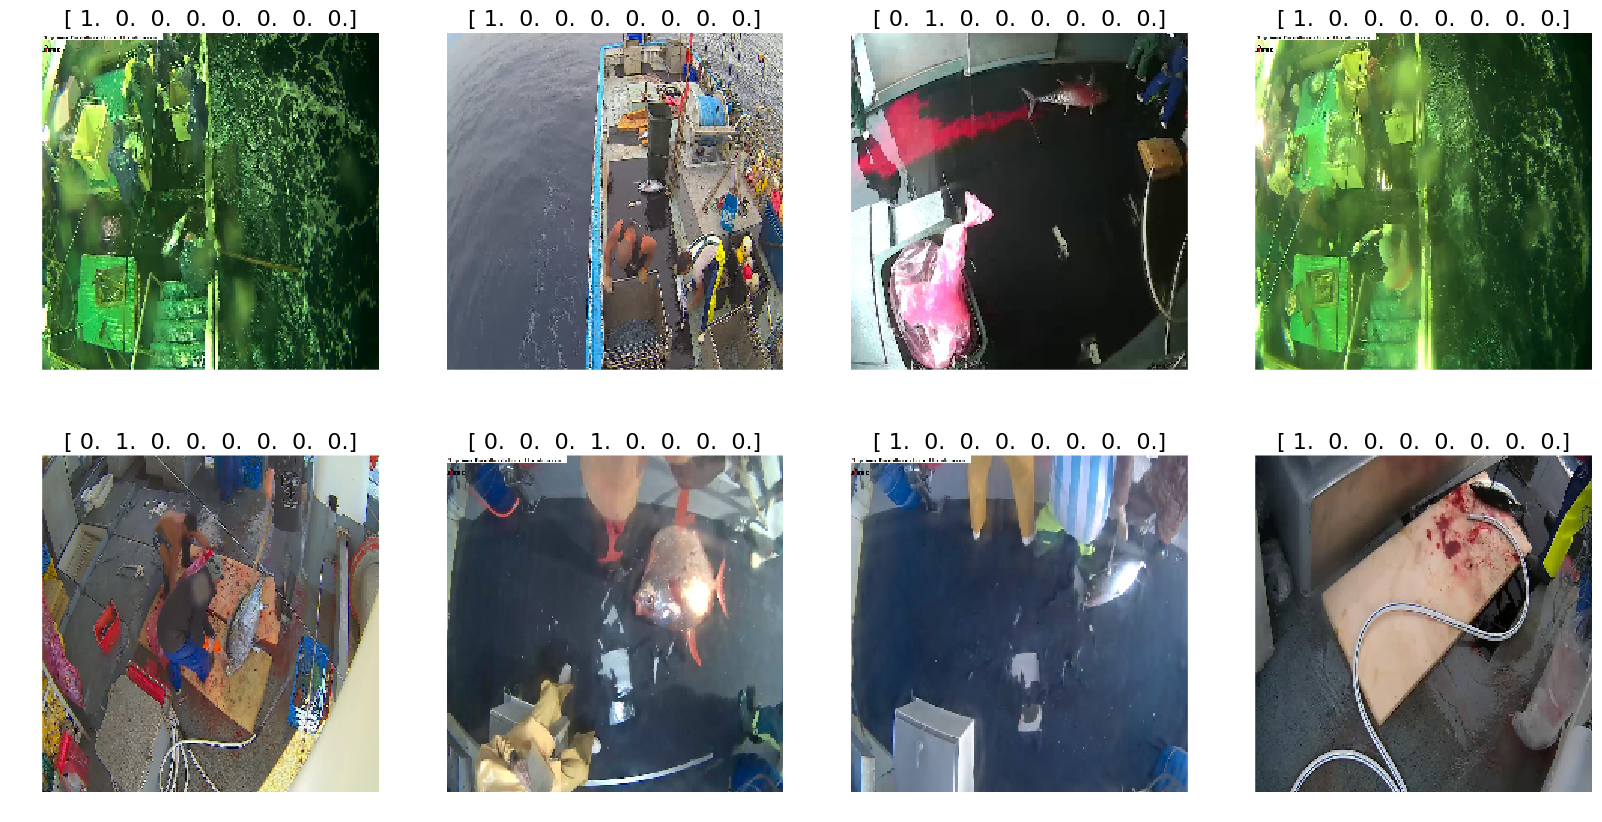

In [23]:
batches = get_batches('train', batch_size=batch_size)
imgs,labels = next(batches)

# Plot randomly 8 images
plots(imgs, titles=labels, figsize=(20,10), rows =2)

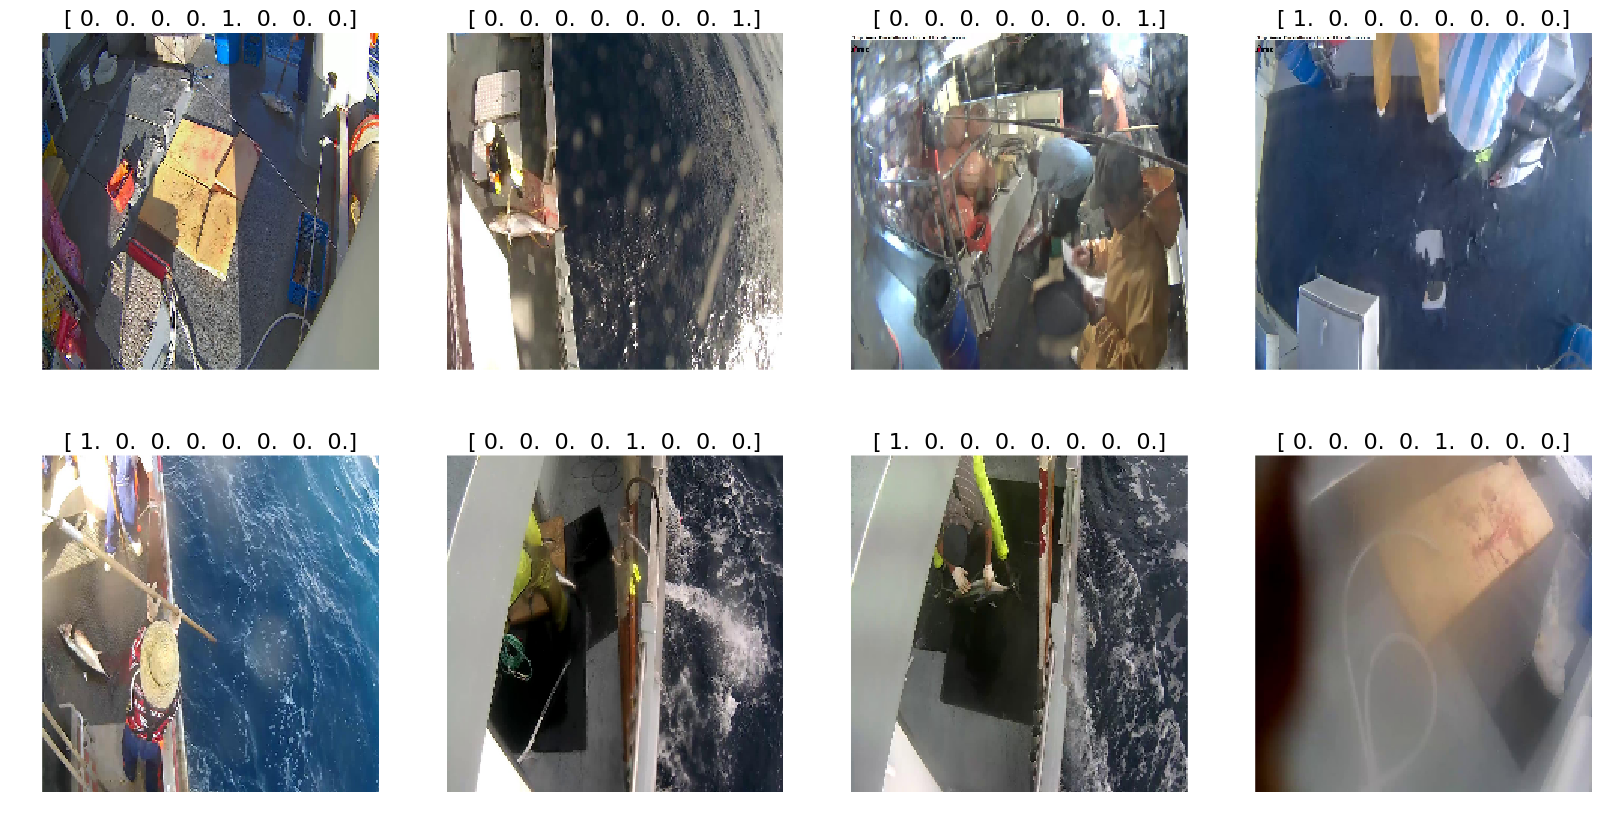

In [9]:
# Plot another 8 images
imgs,labels = next(batches)
plots(imgs, titles=labels, figsize=(20,10), rows =2)

### Summary and general observations

Observations:

1. We only have 3368 training images (90% of the total images-the other 10% are for validation). The dataset is clearly not a big one.

2. The dataset also seems to be skewed for the first category. Its images keep come up dominantly.

3. Look at sample images, the fishes are not at the center of the images, sometimes they are not easy to spot even with human eyes. Apparently, these images are taken from cameras fixed in each boat. Even worse, there are so many features in the images that can potentially cause leakage such as the sea colors (different fishing areas have different see colors), the boat setup, image sizes, etc. There are probably neccessary to done two step learning:



- Object detection to single out the fish

- Object classification

Based on these observations, the following ideas might be helpful

- We might need some data augmmentation

- We can take advantage of image sizes as another input to our model

- In order to help our models to learn the right features, here is the fishes, it is better to manually annotate a bounding box for each fish. Luckily for Kaggle competition, someone will eventually do it. We will use dataset with bounding box [here](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/discussion/25902).


# 3. Data preprocessing


## 3.1 Roll all the image data into array and batches


<span style="color:red"> Warning: The following code blocks take long time to run and consume a lot of memmory. They should only be run once, probabaly on a AWS instance, then download and save locally. </span>


 Get batches of one image each.

In [108]:
# Get every image in to a batch
train_batches = get_batches('train', shuffle=False, batch_size=1, class_mode=None, target_size=(224,224))

Found 3368 images belonging to 8 classes.


In [102]:
val_batches = get_batches('valid', shuffle=False, batch_size=1, class_mode=None, target_size=(224,224))

Found 409 images belonging to 8 classes.


Concatinate all image data into matrices

In [111]:
# Roll into pixcel matrix
train_data = np.concatenate([train_batches.next() for i in range (train_batches.nb_sample)])

MemoryError: 

In [103]:
# Pick all the images and roll each into a matrix.
val_data = np.concatenate([val_batches.next() for i in range(val_batches.nb_sample)])

In [110]:
val_data[0]

array([[[ 255.,  255.,  254., ...,  136.,  139.,  138.],
        [ 250.,  255.,  255., ...,  135.,  140.,  139.],
        [ 255.,  130.,   56., ...,  142.,  139.,  139.],
        ..., 
        [  85.,   83.,   83., ...,   98.,  118.,  125.],
        [  85.,   83.,   83., ...,   97.,  115.,  123.],
        [  85.,   83.,   83., ...,   96.,  113.,  123.]],

       [[ 254.,  253.,  255., ...,  151.,  150.,  149.],
        [ 255.,  254.,  253., ...,  150.,  151.,  150.],
        [ 254.,  125.,   34., ...,  154.,  153.,  153.],
        ..., 
        [  86.,   87.,   87., ...,   99.,  120.,  127.],
        [  86.,   87.,   87., ...,   98.,  117.,  125.],
        [  86.,   87.,   87., ...,   97.,  115.,  125.]],

       [[ 250.,  252.,  250., ...,  172.,  172.,  169.],
        [ 255.,  255.,  254., ...,  181.,  173.,  170.],
        [ 252.,  122.,   36., ...,  204.,  182.,  182.],
        ..., 
        [  91.,   90.,   90., ...,  101.,  107.,  116.],
        [  91.,   90.,   90., ...,  100., 

We only want to compute these data pnce, so it is better to save them.

In [ ]:
# We do not want to recompute the costly operation above again, so it is better to save it
import bcolz
def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()
save_array(path+'results/val.dat', val_data)
save_array('results/train.data', train_data)

<span style="color:red">### End Warning #### </span>

Load the save train and validation data

In [ ]:
train_data = bcolz.open('results/train.dat')[:]
val_data = bcolz.open('results/val.dat')[:]



## 3.1 Get the sizes of images 
Since we detected images has differient sizes in this dataset. We can potentially use this information as an input to our learning model. This may help or may not. 

<span style="color:red"> Warning: </span>
One important thing to note here is that this information is regarded as a leakage in the dataset. Utilize this information may force the neural networks to learn other features rather than the fishes themsefl to have better classification accuracy.


In [26]:
def get_classes(path):
    batches = get_batches('train', shuffle=False, batch_size=1)
    val_batches = get_batches('valid', shuffle=False, batch_size=1)
    test_batches = get_batches('test', shuffle=False, batch_size=1)
    return (val_batches.classes, batches.classes,to_categorical(val_batches.classes),
            to_categorical(batches.classes),val_batches.filenames, batches.filenames,
            test_batches.filenames)

In [28]:
(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)
raw_filenames = [f.split('/')[-1] for f in filenames]
raw_test_filenames = [f.split('/')[-1] for f in test_filenames]
raw_val_filenames = [f.split('/')[-1] for f in val_filenames]

Found 3368 images belonging to 8 classes.
Found 409 images belonging to 8 classes.
Found 1000 images belonging to 1 classes.


In [29]:
# Get the file name and assign each name with an id
file2idx = {o:i for i,o in enumerate(raw_filenames)}
val_file2idx = {o:i for i,o in enumerate(raw_val_filenames)}

In [30]:
import PIL
from PIL import Image
import collections

# get all the sizes of all images in our train dataset
train_sizes = [PIL.Image.open(path+'train/'+f).size for f in filenames]

train_sizes[0:10]

[(1280, 750),
 (1280, 720),
 (1280, 720),
 (1280, 974),
 (1276, 718),
 (1280, 720),
 (1276, 718),
 (1280, 720),
 (1280, 974),
 (1280, 720)]

In [31]:
# see how many unique image sizes that we have here
collections.Counter(train_sizes)

Counter({(1192, 670): 176,
         (1244, 700): 23,
         (1276, 718): 203,
         (1280, 720): 1929,
         (1280, 750): 534,
         (1280, 924): 52,
         (1280, 974): 359,
         (1334, 750): 28,
         (1518, 854): 34,
         (1732, 974): 30})

So, we have 10 different sizes. Remember that we have 8 categories. So, there might be some correlation between categories and images sizes. Who knows? But we can just take this as another input.

Before we do that we need to encode images (onehot) in order to have a numerical input.

### Encoding train and validation data with their image sizes

In [32]:
# create mapping between image id and its size
id2size = list(set(train_sizes))
size2id = {o:i for i,o in enumerate(id2size)}
# So, each size has its own id
size2id

{(1192, 670): 4,
 (1244, 700): 1,
 (1276, 718): 6,
 (1280, 720): 5,
 (1280, 750): 0,
 (1280, 924): 8,
 (1280, 974): 7,
 (1334, 750): 3,
 (1518, 854): 9,
 (1732, 974): 2}

In [33]:
# Onehot encode each image according to its sizes. 
# Rememeber that we have 10 sizes, therefore each images will get assigned to a 10-value long vector
train_encode = to_categorical([size2id[o] for o in train_sizes], len(id2size))

train_encode[0:10]

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])

Similarly, we also encode the validation dataset

In [34]:
val_sizes = [PIL.Image.open(path+'valid/'+f).size for f in val_filenames]
val_encode = to_categorical([size2id[o] for o in val_sizes], len(id2size))

### Nornalize encoded data
It is always a good idea to normalize the dataset around its mean to avoid bias.

In [35]:
train_encode_norm = train_encode-train_encode.mean(axis=0)/train_encode.std(axis=0)
valid_encode_norm = val_encode-train_encode.mean(axis=0)/train_encode.std(axis=0)

# See it
train_encode_norm[0:10]

array([[ 0.5659, -0.0829, -0.0948, -0.0916, -0.2348, -1.1578, -0.2533, -0.3454, -0.1252, -0.101 ],
       [-0.4341, -0.0829, -0.0948, -0.0916, -0.2348, -0.1578, -0.2533, -0.3454, -0.1252, -0.101 ],
       [-0.4341, -0.0829, -0.0948, -0.0916, -0.2348, -0.1578, -0.2533, -0.3454, -0.1252, -0.101 ],
       [-0.4341, -0.0829, -0.0948, -0.0916, -0.2348, -1.1578, -0.2533,  0.6546, -0.1252, -0.101 ],
       [-0.4341, -0.0829, -0.0948, -0.0916, -0.2348, -1.1578,  0.7467, -0.3454, -0.1252, -0.101 ],
       [-0.4341, -0.0829, -0.0948, -0.0916, -0.2348, -0.1578, -0.2533, -0.3454, -0.1252, -0.101 ],
       [-0.4341, -0.0829, -0.0948, -0.0916, -0.2348, -1.1578,  0.7467, -0.3454, -0.1252, -0.101 ],
       [-0.4341, -0.0829, -0.0948, -0.0916, -0.2348, -0.1578, -0.2533, -0.3454, -0.1252, -0.101 ],
       [-0.4341, -0.0829, -0.0948, -0.0916, -0.2348, -1.1578, -0.2533,  0.6546, -0.1252, -0.101 ],
       [-0.4341, -0.0829, -0.0948, -0.0916, -0.2348, -0.1578, -0.2533, -0.3454, -0.1252, -0.101 ]])

## 3.2 Get the bounding box and assign to images 

Next, we will take advantage of bounding boxes to identify the fishes.

We only take the largest bounding box for each image.

### Loading boxes information

In [36]:
import ujson as json
# Annotations' labels
anno_labels = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']
bbox = {}
for c in anno_labels:
    i = json.load(open('{}Box/{}_labels.json'.format(path, c), 'r'))
    for j in i:
        if 'annotations' in j.keys() and len(j['annotations'])>0:
            bbox[j['filename'].split('/')[-1]] = sorted(
                j['annotations'], key=lambda x: x['height']*x['width'])[-1]

Normally, a bounding box will contain information about the x and y coordinates of the bottom left corners of box together with width and height of the box. 
Let's see

In [37]:
bbox['img_04279.jpg']

{u'class': u'rect',
 u'height': 317.0000000000008,
 u'width': 392.0000000000009,
 u'x': 604.0000000000015,
 u'y': 169.0000000000004}

### Preprocessing the boxes

We need to put an empty bounding box to each image that doesn't have annotation.

In [38]:
empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}
for f in raw_filenames:
    if not f in bbox.keys(): bbox[f] = empty_bbox
for f in raw_val_filenames:
    if not f in bbox.keys(): bbox[f] = empty_bbox

We also need to convert the box according to image size since we plan to scale all the image to 224x224.

In [39]:
# Helper function to scale all the boxes to corresponding to
# the scalling of images to 224x224.
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params]
    conv_x = (224. / size[0])
    conv_y = (224. / size[1])
    bb[0] = bb[0]*conv_y
    bb[1] = bb[1]*conv_x
    bb[2] = max(bb[2]*conv_x, 0)
    bb[3] = max(bb[3]*conv_y, 0)
    return bb

In [40]:
train_bbox = np.stack([convert_bb(bbox[f], s) for f,s in zip(raw_filenames, train_sizes)], 
                   ).astype(np.float32)
val_bbox = np.stack([convert_bb(bbox[f], s) 
                   for f,s in zip(raw_val_filenames, val_sizes)]).astype(np.float32)

train_bbox[0:5]

array([[  46.4588,   70.8601,  130.9146,  176.6142],
       [  50.8285,   37.7284,  115.9854,  100.0851],
       [  32.1399,   15.7929,  140.2657,   69.4517],
       [  99.5811,   21.175 ,   48.475 ,   40.9363],
       [  33.3816,   20.8903,   83.9122,   88.6017]], dtype=float32)

### Plot the boxes
Now we are ready to plot some boxes to our image data. First we neet to design the box appreance.

In [98]:
def create_rect(bb, color='green'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)


And, we are ready to plot. We just take a bit more care about dimemsion ordering difference between Tensorflow and Theano.

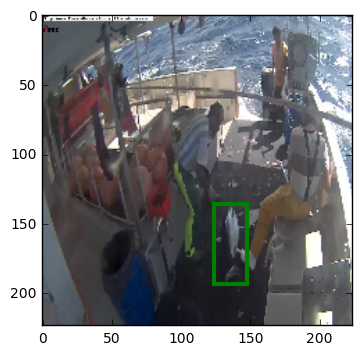

In [99]:
def show_bb(i):
    bb = val_bbox[i]
    #plot(val_data[i])
    if K.image_dim_ordering() == 'tf':
        img = np.rollaxis(val_data[i], 0, 1).astype(np.uint8)
    else:
        img = np.rollaxis(val_data[i], 0, 3).astype(np.uint8)
    plt.imshow(img)
    plt.gca().add_patch(create_rect(bb))
show_bb(0)

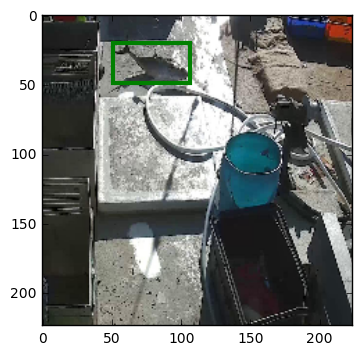

In [100]:
show_bb(10)

Well, we can see that the image boxing is done pretty well.

# 4. Building Models

Before diving deep into playing around with models and architectures, we should plan clearly what we want to do. This is to keep our thinking clear and avoid messing up with different resutls and ideas because having many models experimented, it is very easy to forget something. 

Overall, for specific images classfication problems like this one, it is almost always a defautl choice to start with some trained models, e.g., vgg16, resnet, or inception with their ImageNet pre-trained weights. There are many good reasons for this. First, the architecture has been tested and proven to work effectively. Second, ImageNet by far is one of the largest and most reliable image data sources. There are 1000 categories, there are a lot of fishes. Moreover, having trained on that dataset, the neural network likely already pickup knowledge about shapes, spacial, gravity, colors, etc.

Now, let's say we start with vgg16 (most poeple do). What layers we want to keep what layers we will retrained? We often do not want to retrain the convolutional layers because those layers are meant to learn important features during training with the ImageNet dataset. So, we want to keep them. 


## A. Convolutional model with Vgg16 + batch normalization

Let's start with standard Vgg model with added batchnorm.

Plan:

- Build a full Vgg model with batch normalization.
- Load pre-trained ImageNet weights.
- Run all the train data and validation data through the vgg model.
- Pop the model to take out Convolutional part.
- Pre-compute output of the convolutional part and store as numpy arrays.
- Experiment the fully connected part with lots of architecture.


 ###  Build a full Vgg16 model with batch norm
 

In [81]:
# Set the batch size
batch_size=64

Preprocessing to make sure the color channels are in correct order. Also, submit all pixcel values from their mean.

In [82]:
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))
def vgg_preprocess(x):
    x = x - vgg_mean
    return x[:, ::-1]

 Create building blockes for Vgg model

In [83]:
def ConvBlock(layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

 Assemble building blockes to a vgg object

In [84]:
def Vggbn():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))

    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)
    
    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

Create an instance of Vgg model and load pre-trained weights.

In [85]:
model = Vggbn()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

### Load the pre-trained ImageNet weights

In [8]:
model.load_weights('vgg16_bn.h5')

### Split layers and create a model contain only convolutional part

Split the convolutional part and the fully connected part. Look at the model summary the final convolution layer is Convoluional2d_13, we will split right there.

In [96]:
# Pop all the layers in Vgg model
layers = model.layers
# Find all the index of Convolution2D layers
Con2D_layer_idx = [index for index,layer in enumerate(layers) if type(layer) is Convolution2D]
# Call the index of the last Convolution2D layer
layer_idx = Con2D_layer_idx[-1]

# Find out what it is
layer_idx

30

So, that is layer 30th in the model. Let's create a convolutional model upto layer 30th of the previous model.

In [97]:
# Create convolutional model up to layer 30
conv_model = Sequential(layers[:layer_idx+1])
# See what does it look like
conv_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
                                                                   lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
                                                                   zeropadding2d_1[1][0]            
___________________________________________________________________________________________

### Load data and precompute the convolutional model output

<span style="color:red"> Warning: These two following operations are computationally costly. Run on server. </span>


In [ ]:
train_conv_out = conv_model.predict(train_data)
val_conv_out = conv_model.predict(val_data)

In [ ]:
save_array('results/train_conv_out.dat', trai_conv_out)
save_array('results/val_conv_out.dat', val_conv_out)

<span style="color:red">### End Warning #### </span>
### Load outputs of Conv layers as new inputs

In [ ]:
train_conv_out = bcolz.open('results/train.dat')[:]
val_conv_out = bcolz.open('results/val.dat')[:]

Check out the shape of the output of Convolutional model

In [ ]:
train_conv_out.shape()

Now, we already have the output from convolutional model as new input to our to-be-design neural networks. It is time to experiment with a lot of architectures and do fine-tuning to find the best combinations.

### Experiment 1. Using Vgg1 default fully connected layers with pre-trained weights

In this experiment, we will not go to far into designing new architectures after convolutional layers. Instead, we stick with the original design of vgg16. Which means we will reuse the fully connected (FC) part of Vgg16 and do a little modification to adapt with our problem. More specifically, we will remove the last FC layer which outputs 1000 softmax values (1000 categories for ImageNet dataset) and we will stick another FC layer that output 8 softmax activation values (8 fish species categories).

We try to take advantage of the pre-trained weights of FC layers as well. So, we will set weights at these layers to be non-trainable.

In [141]:
FC_vgg_model = Sequential(layers[layer_idx+1:layer_idx+9])
for layer in FC_vgg_model.layers: layer.trainable = False

In [142]:
# Add another FC layer that output 8 values on top
FC_vgg_model.add(Dense(8, activation = 'softmax'))

# Compile. It is always safe to compile
FC_vgg_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [143]:
FC_vgg_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
maxpooling2d_5 (MaxPooling2D)    (None, 512, 7, 7)     0           convolution2d_13[0][0]           
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 25088)         0           maxpooling2d_5[0][0]             
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 4096)          102764544   flatten_1[13][0]                 
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 4096)          16384       dense_1[13][0]                   
___________________________________________________________________________________________

*** Training***

In [ ]:
batch_size = 30
FC_vgg_model.optimizer.lr = 0.0001
FC_vgg_model.fit(train_conv_out, trn_labels, batch_size=batch_size, nb_epoch=3, 
             validation_data=(val_conv_out, val_labels))

In [144]:
FC_vgg_model.optimizer.lr = 1e-4

In [ ]:
FC_vgg_model.fit(train_conv_out, trn_labels, batch_size=batch_size, nb_epoch=3, 
             validation_data=(val_conv_out, val_labels))

*** Saving weights and Evaluating***

In [ ]:
FC_vgg_model.save_weights(path+'models/Ex_1_FC_vgg_model.h5')

In [ ]:
# Evaluate method returns loss and accuracy of the model
FC_vgg_model.evaluate(val_conv_out, val_labels)

### Experiment 2. Using vgg16 default model but train entire FC layers
This experiment is similar to previous experiment except for we now train all layers. Note that due to batch normalization was invented after the introduction of vgg16, therefore, in the previous model the batch normalization pre-trained parameters were adapted with ImageNet dataset and fixed. We cannot train them if we reuse the architecture. Instead, we will construct those layers of vgg16 model from scratch.

In [151]:
def FC_vgg_trainable_model(p):
    model = Sequential()
    model.add(MaxPooling2D(input_shape=layers[:layer_idx+1][-1].output_shape[1:])) # Theano shape
    model.add(Flatten()) 
    model.add(Dense(4096, activation='relu'))
    model.add(BatchNormalization(axis=1))
    model.add(Dropout(p))
    model.add(Dense(4096, activation='relu'))
    model.add(BatchNormalization(axis=1))
    model.add(Dropout(p))
    model.add(Dense(8, activation='softmax'))
    return model

In [152]:
FC_vgg_traiable_model = FC_vgg_trainable_model(0.5)
FC_vgg_traiable_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
maxpooling2d_6 (MaxPooling2D)    (None, 512, 7, 7)     0           maxpooling2d_input_1[0][0]       
____________________________________________________________________________________________________
flatten_2 (Flatten)              (None, 25088)         0           maxpooling2d_6[0][0]             
____________________________________________________________________________________________________
dense_11 (Dense)                 (None, 4096)          102764544   flatten_2[0][0]                  
____________________________________________________________________________________________________
batchnormalization_3 (BatchNorma (None, 4096)          16384       dense_11[0][0]                   
___________________________________________________________________________________________

*** Training***

In [ ]:
batch_size = 30
FC_vgg_trainable_model.optimizer.lr = 0.0001
FC_vgg_trainable_model.fit(train_conv_out, trn_labels, batch_size=batch_size, nb_epoch=3, 
             validation_data=(val_conv_out, val_labels))

In [ ]:
FC_vgg_trainable_model.optimizer.lr = 1e-4
FC_vgg_trainable_model.fit(train_conv_out, trn_labels, batch_size=batch_size, nb_epoch=5, 
             validation_data=(val_conv_out, val_labels))

*** Saving weights ***

In [ ]:
FC_vgg_trainable_model.save_weights(path+'models/Ex_2_FC_vgg_trainable_model.h5')

In [ ]:
# Evaluate method returns loss and accuracy of the model
FC_vgg_trainable_model.evaluate(val_conv_out, val_labels)

## Experiment 3: Build a customized FC network with batchnorm

In [153]:
def FC_layers(p):
    return [
        MaxPooling2D(input_shape=layers[:layer_idx+1][-1].output_shape[1:]),
        BatchNormalization(axis=1),
        Dropout(p/4),
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p/2),
        Dense(8, activation='softmax')
    ]

In [154]:
p=0.5

In [157]:
FC_model = Sequential(FC_layers(p))
FC_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
FC_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
maxpooling2d_9 (MaxPooling2D)    (None, 512, 7, 7)     0           maxpooling2d_input_4[0][0]       
____________________________________________________________________________________________________
batchnormalization_11 (BatchNorm (None, 512, 7, 7)     2048        maxpooling2d_9[0][0]             
____________________________________________________________________________________________________
dropout_11 (Dropout)             (None, 512, 7, 7)     0           batchnormalization_11[0][0]      
____________________________________________________________________________________________________
flatten_5 (Flatten)              (None, 25088)         0           dropout_11[0][0]                 
___________________________________________________________________________________________

*** Training ***

In [ ]:
batch_size = 30
FC_model.optimizer.lr = 0.0001
FC_model.fit(train_conv_out, trn_labels, batch_size=batch_size, nb_epoch=3, 
             validation_data=(val_conv_out, val_labels))

In [ ]:
FC_model.optimizer.lr = 1e-4
FC_model.fit(train_conv_out, trn_labels, batch_size=batch_size, nb_epoch=5, 
             validation_data=(val_conv_out, val_labels))

*** Saving weights ***

In [ ]:
FC_model.save_weights(path+'models/Ex_3_FC_model.h5')

In [ ]:
# Evaluate method returns loss and accuracy of the model
FC_model.evaluate(val_conv_out, val_labels)

### Experiment 4.  Using mutiple input: adding the box location as another input 

In [158]:
p=0.6

In [160]:
inp = Input(layers[:layer_idx+1][-1].output_shape[1:])
x = MaxPooling2D()(inp)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x_bb = Dense(4, name='bb')(x)
x_class = Dense(8, activation='softmax', name='class')(x)

In [161]:
Multi_input_model = Model([inp], [x_bb, x_class])
Multi_input_model.compile(Adam(lr=0.001), loss=['mse', 'categorical_crossentropy'], metrics=['accuracy'],
             loss_weights=[.001, 1.])

*** Training ***

In [ ]:
batch_size = 30
Multi_input_model.fit(train_conv_out, [train_bbox, trn_labels], batch_size=batch_size, nb_epoch=3, 
             validation_data=(val_conv_out, [val_bbox, val_labels]))

In [ ]:
Multi_input_model.optimizer.lr = 1e-4

In [ ]:
Multi_input_model.fit(train_conv_out, [train_bbox, trn_labels], batch_size=batch_size, nb_epoch=3, 
             validation_data=(val_conv_out, [val_bbox, val_labels]))

*** Saving weights***


In [ ]:
Multi_input_model.save_weights(path+'models/Ex_4_Multi_input_model.h5')

In [ ]:
# Evaluate method returns loss and accuracy of the model
Multi_input_model.evaluate(val_conv_out, val_labels)

### Experiment 5. Use the image size as another input

### Experiment 6. Use larger image size

### Experiment 7. Use data augmentation

### Experiment 8. Use psuedo-labeling

### Experiment 9. Use resnes

### Experiment 10. Use a small Inception

### Experiment 11. Ensembles